In [ ]:
import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt

import ast

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.tree import DecisionTreeClassifier

## In this notebook, I test different machine learning methods to predict genre of songs, using sentiment. These will be used in the ensemble model.

In [ ]:
sent_data_subset_lines = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_clean_sentiment_lines.csv')

In [ ]:
sent_data_subset_lines

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment
0,0,78168,franz ferdinand,swallow smile,Rock,en,I rise and curse the waking day\nCurse the gri...,0
1,1,155890,ry cooder,big bad bill is sweet william now,Rock,en,In the town of Louisville they got a man they ...,-1
2,2,52293,daryl hall,let me be the one,Rock,en,We've been through love time & time again\nTri...,2
3,3,130715,"mullins, shawn",we run,Rock,en,in the town that i was born in\nthere rides a ...,1
4,4,169162,stray cats,reckless,Rock,en,Well I met you in the backroom\nYou had lipsti...,-1
...,...,...,...,...,...,...,...,...
14995,14995,102055,jonathan mcreynolds,l.r.f. (move that over),R&B,en,my friends\nmy family\nmy relationships\nwhate...,1
14996,14996,40227,calibretto 13,soul stalker,R&B,en,Darkness bathes the city face. It's something ...,-2
14997,14997,155313,ruben studdard,to da crib,R&B,en,"Let's go, let's go, KL\nLet's go, let's go\nLe...",1
14998,14998,117950,luther vandross,i know,R&B,en,I know that you've been good to me\nAnd I know...,-1


### 1. Split data into training and testing, use same split as in the other content model

In [ ]:
# stratify so it doesn't just grab a couple of the genres. it needs to sample from all the genres
train_lr_sent, val_lr_sent = train_test_split(sent_data_subset_lines, test_size=0.2, random_state=24, stratify = sent_data_subset_lines['Genre'])

In [ ]:
print(train_lr_sent['Genre'].value_counts())
print(val_lr_sent['Genre'].value_counts())

Metal         1200
Folk          1200
Country       1200
Hip-Hop       1200
Rock          1200
Jazz          1200
Electronic    1200
Pop           1200
Indie         1200
R&B           1200
Name: Genre, dtype: int64
Hip-Hop       300
Country       300
Pop           300
Folk          300
R&B           300
Jazz          300
Rock          300
Electronic    300
Indie         300
Metal         300
Name: Genre, dtype: int64


In [ ]:
X_train = train_lr_sent['Sentiment']
y_train = train_lr_sent['Genre']

X_val = val_lr_sent['Sentiment']
y_val = val_lr_sent['Genre']

### 2. Logistic Regression

#### a. Train the model

In [ ]:
model_lr_sent = LogisticRegression(max_iter=10000, penalty = 'l2')
model_lr_sent.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

y_pred = model_lr_sent.predict(np.array(X_val).reshape(-1,1))

#### b. Evaluate the model

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
#classification_report = classification_report(y_val, y_pred)

In [ ]:
print("Validation Accuracy:", accuracy)
#print("Validation Classification Report:\n", classification_report)

Validation Accuracy: 0.152


In [ ]:
class_indices = model_lr_sent.classes_
class_indices

array(['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock'], dtype=object)

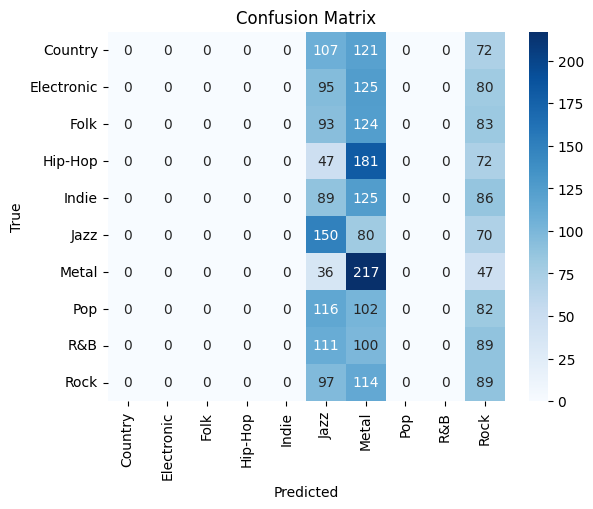

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_pred, labels = genre_names)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 3. K-Nearest-Neighbors (knn)

#### a. Train the model

In [ ]:
dif_k_results = []
# note: only odd numbers bc ties

for k in range(1,101,2):
  model_knn_sent = KNeighborsClassifier(n_neighbors = k)
  model_knn_sent.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

  y_pred = model_knn_sent.predict(np.array(X_val).reshape(-1,1))

  accuracy = accuracy_score(y_val, y_pred)

  dif_k_results.append(accuracy)

In [ ]:
# dif_k_results
# max was k = 73

#### b. Evaluate the best model

  run knn with the best k (73)

In [ ]:
model_knn_sent = KNeighborsClassifier(n_neighbors = 73)
model_knn_sent.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

y_pred = model_knn_sent.predict(np.array(X_val).reshape(-1,1))

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.153


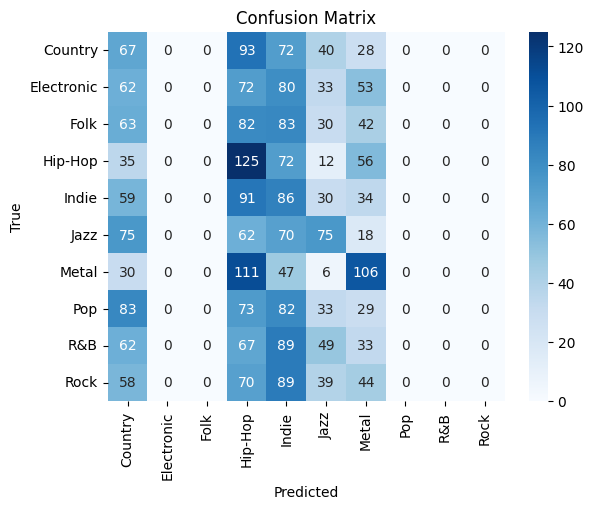

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_pred, labels = genre_names)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 4. Naive Bayes Model

#### a. Train The Model

Calculating the percentage of songs in each genre

In [ ]:
genre_percent = sent_data_subset['Genre'].value_counts(normalize=True) * 100
genre_percent

Rock          10.0
Pop           10.0
Metal         10.0
Jazz          10.0
Indie         10.0
Hip-Hop       10.0
Folk          10.0
Country       10.0
Electronic    10.0
R&B           10.0
Name: Genre, dtype: float64

In [ ]:
priors = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [ ]:
model_nb_sent = GaussianNB(priors=priors)
model_nb_sent.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

GaussianNB(priors=[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [ ]:
y_pred = model_nb_sent.predict(np.array(X_val).reshape(-1,1))

#### b. Evaluate the Model

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.151


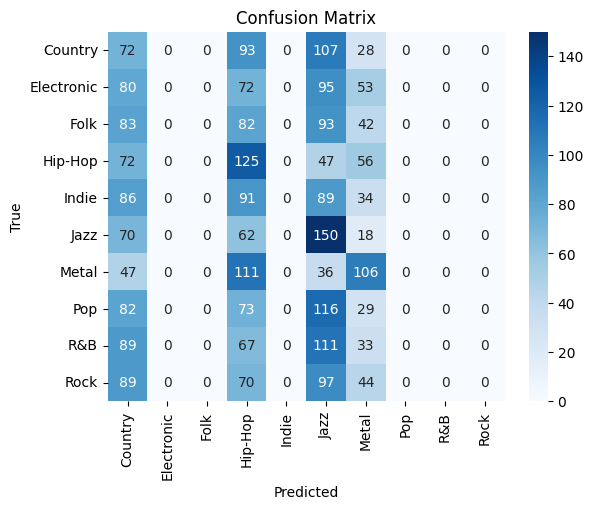

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_pred, labels = genre_names)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### 5. Decision Tree Classifier

In [ ]:
model_dtc_sent = DecisionTreeClassifier()
model_dtc_sent.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))

DecisionTreeClassifier()

In [ ]:
y_pred = model_dtc_sent.predict(np.array(X_val).reshape(-1,1))

In [ ]:
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.153


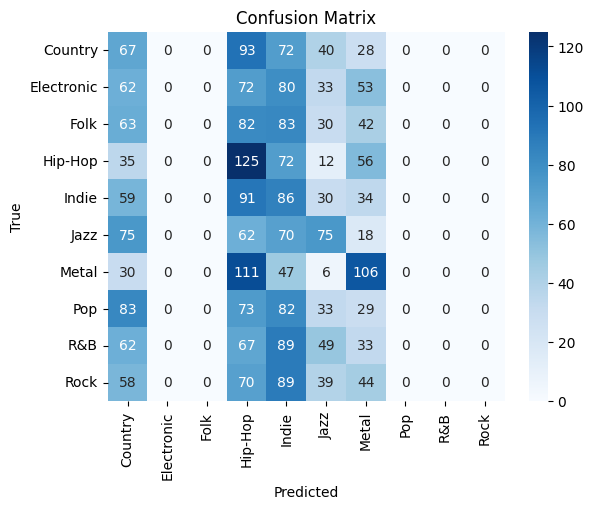

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']

cm = confusion_matrix(y_val, y_pred, labels = genre_names)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()